<a href="https://colab.research.google.com/github/desmond-rn/inverse-problem-vnet/blob/master/notebooks/new_vnet_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simplifcation d'un VNET pour la reconstruction de la densité d'un domaine

L'objectif de ce notebook est de **reconstruire la dénsité d'un domaine** à l'aide des signaux récupérés sur ses quatres bords. Il s'agit d'un problème inverse qu'on va résoudre à l'aide d'un Vnet. 

In [92]:
%reset -f

In [93]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import sklearn
from sklearn import metrics
import struct
from keras import backend as K


import gc
from IPython.display import Image
from ast import literal_eval as l_eval

In [94]:
np.set_printoptions(precision = 3)

## Les données

In [95]:
""" DEPUIS GOOGLE DRIVE """
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [96]:
%cd ~
%cd /gdrive/My\ Drive
%cd Colab\ Notebooks/InverseProblem/data
print()

%ls

/root
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks/InverseProblem/data

df_simu.csv  img/  test/  train/  val/


### Desciption des données

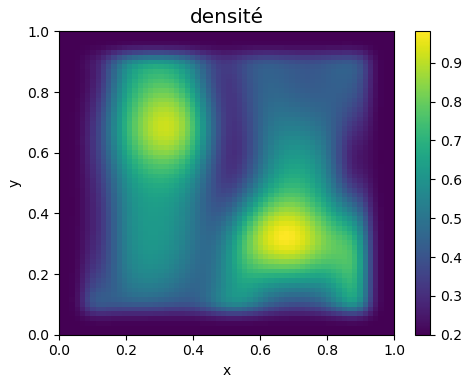

In [97]:
## La sortie du réseau de neurones
Image("../notebooks/img/DensiteTest.png",width="500")

On change le bord sur lequel se trouve la source et on relance des simulations. Mais **contrarement aux entrainements précédents**, nous ne conservons que le signal à l'opposé de la source vue de l'entrainement (les trois cannaux dudit signal). Ce qui nous donne au total $4 \times 1 \times 3 = 12$ cannaux pour les antrées. La figure ci-bas illutre la simplification apportée !

In [98]:
## Input for the Vnet
Image("../notebooks/img/SimplifiedSimuCirculaires.png",width="1600")

### Recupération des données

Comme on pourra le constater ci-bas, les données ont été prétraitées (reéchantillonées, normalisées, shufflelisées, etc.) dans un notebook précédent.

In [99]:
X_train = np.load("train/newX.npy")
Y_train = np.load("train/Y.npy")
print("Train shapes", X_train.shape, Y_train.shape)
print()
print("X Max and Min: ", X_train.max(), X_train.min())
print("Y Max and Min: ", Y_train.max(), Y_train.min())

Train shapes (1950, 64, 64, 12) (1950, 64, 64, 1)

X Max and Min:  0.72943336 0.0
Y Max and Min:  1.0 0.10091702238501658


In [100]:

X_val = np.load("val/newX.npy")
Y_val = np.load("val/Y.npy")
print("Validation shapes", X_val.shape, Y_val.shape)

Validation shapes (750, 64, 64, 12) (750, 64, 64, 1)


In [101]:
X_test = np.load("test/newX.npy")
Y_test = np.load("test/Y.npy")[:,:,:,0]   ## derniere dimension inutile pour les plots
print("Test shapes", X_test.shape, Y_test.shape)

Test shapes (183, 64, 64, 12) (183, 64, 64)


## Description du Unet et du Vnet

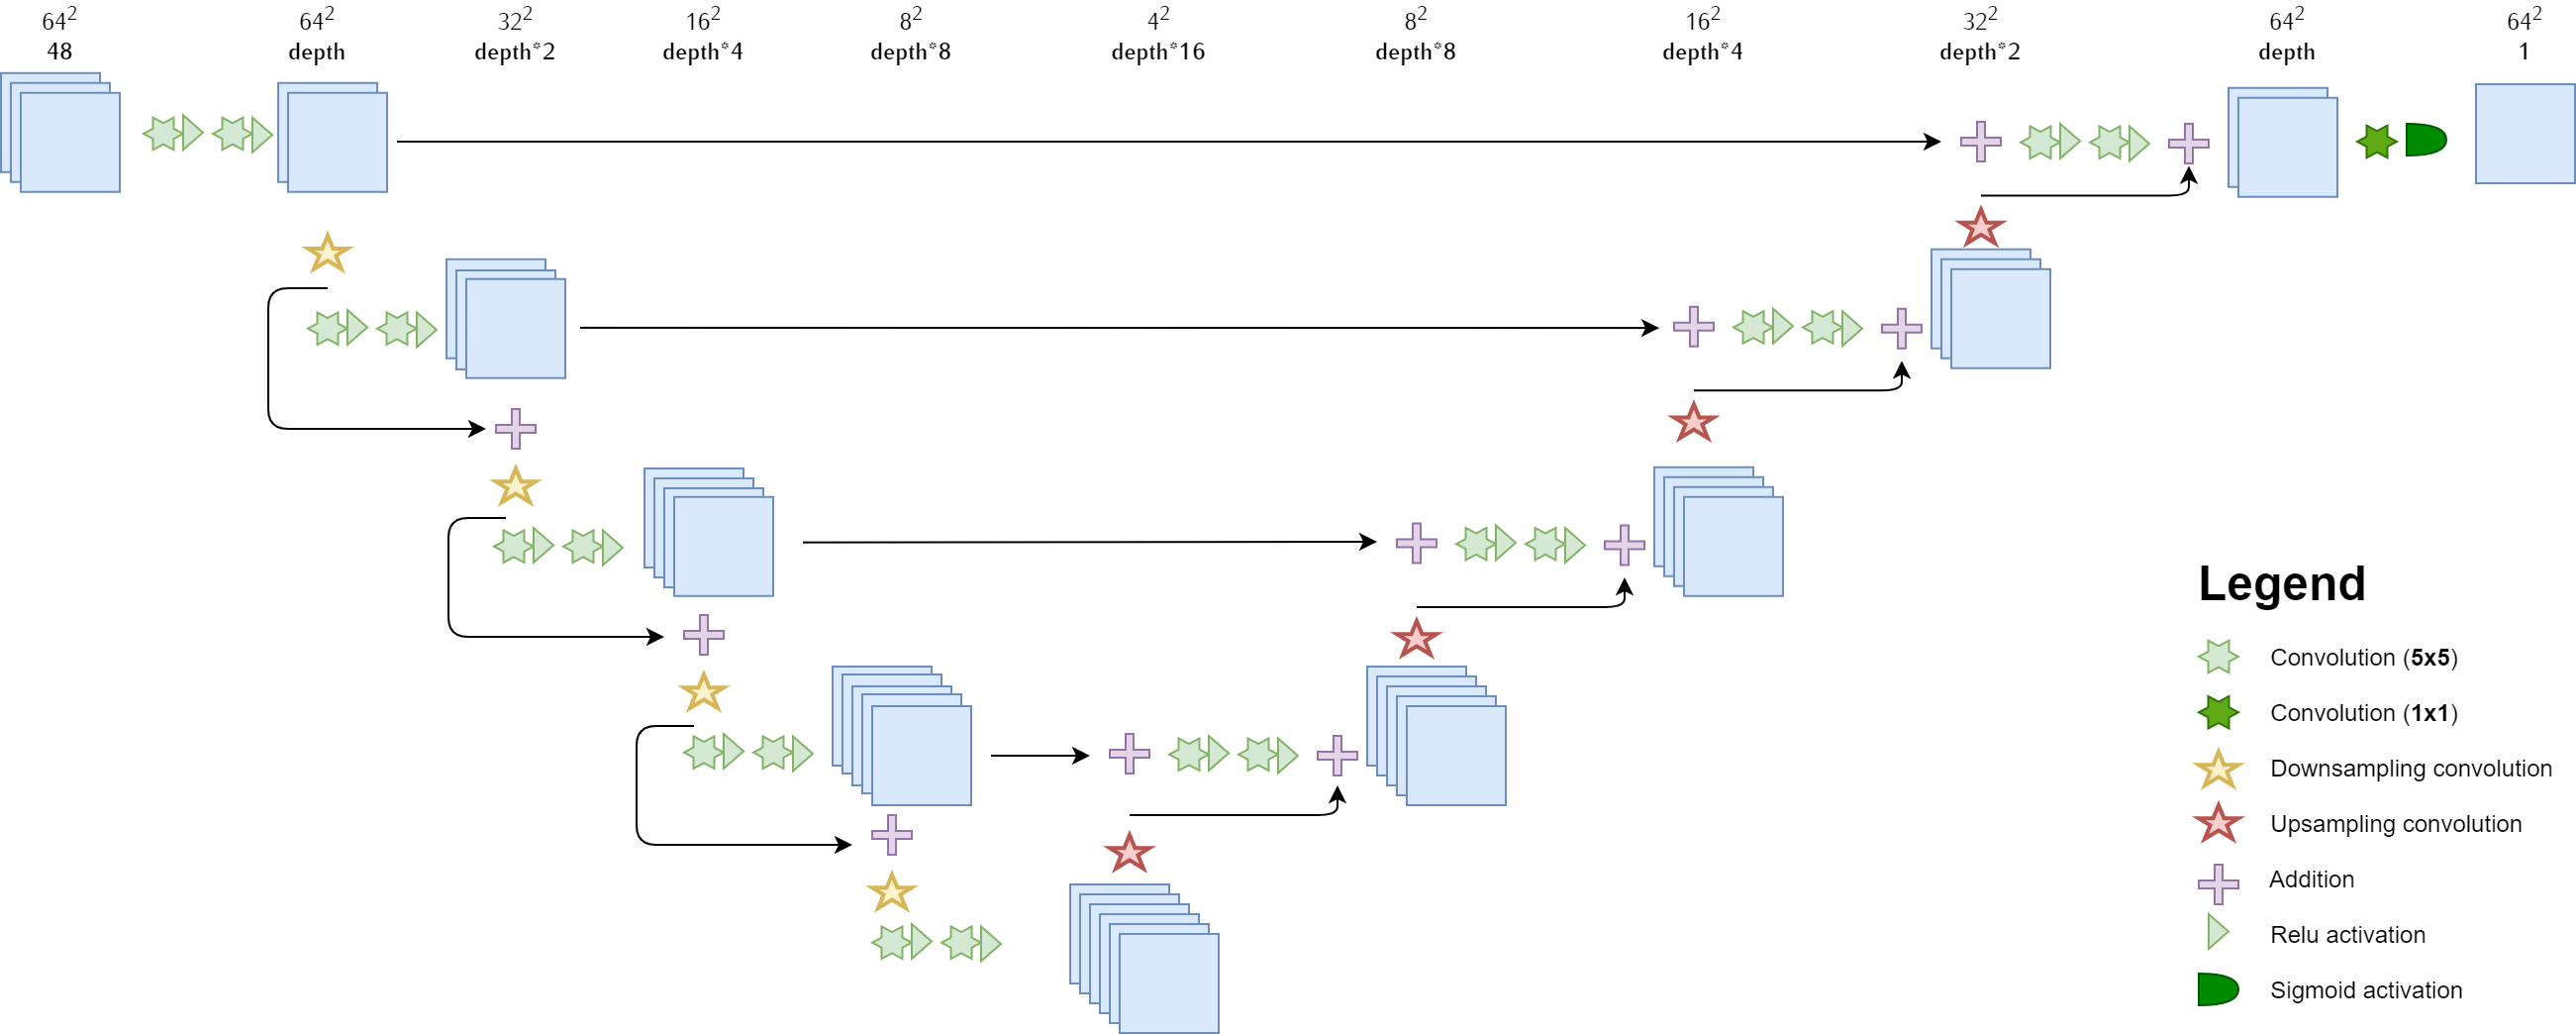

In [102]:
Image("../notebooks/img/Vnet.png",width="800")

## Construction du Vnet

In [103]:
Conv = tf.keras.layers.Conv2D                           ## Convolution
DeConv = tf.keras.layers.Conv2DTranspose                ## Deconvolution
SpatialDropout = tf.keras.layers.SpatialDropout2D       ## Dropout

class VNet:
    
    def __init__(self,
                 input_shape,
                 output_shape,                  
                 levels=5,                      ## Le nombre de niveaux 
                 depth=32,                       ## Le nombre de channel au niveau 1
                 kernel_size=5, 
                 activation="relu",
                 batch_norm=True,
                 dropout_rate=0, 
                 ): 

        self.input_shape=input_shape
        self.output_shape=output_shape
        self.levels = levels
        self.depth = depth
        self.kernel_size = kernel_size
        self.activation = activation
        self.batch_norm=batch_norm
        self.dropout_rate = dropout_rate

        assert len(input_shape)==3
        assert len(output_shape)==3
        assert (input_shape[0], input_shape[1]) == (output_shape[0], output_shape[1]), "Input and output dimensions should be alike in a VNET"

        ##---------- Le model, ses inputs et des outputs -----------##
        inputs= tf.keras.Input(shape=input_shape)
        logits= self.body(inputs)

        if self.output_shape[2]==1:    ## Output number of channels equals 1
            outputs = Conv(1,1, activation='sigmoid')(logits)                         ## On utilise une sigmoid parceque les donnees ont éte normalisées
        else:   
            outputs = Conv(self.input_shape[2],1, activation='softmax')(logits)       ## Le softmax peut servir a avoir une image RGB par exemple, c'est pas specifiquement lié à la classification

        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
        ##----------------------------------------------------------##
        
    def doubleConv(self, Y, depth):
        Y = Conv(depth, self.kernel_size,activation=self.activation,padding='same')(Y)    ## On pourra essayer avec valid comme dans le papier!
        Y = Conv(depth, self.kernel_size,activation=self.activation,padding='same')(Y)
        if self.batch_norm:
            Y = tf.keras.layers.BatchNormalization()(Y)
        if self.dropout_rate>0:                             ## S'il n'ya pas de dropout, on ne fait rien !
            Y = SpatialDropout(self.dropout_rate)(Y)        ## Dans le SpatialDropout, si on cache une portion de l'image, on la cahe totalement. Pas la peine de chacher seulement certains neurones! 
        return Y

    def makeDown(self, Y, depth):       ## Une simple descente d'un level au suivant
        down = Conv(depth, 2, strides=2, padding="same")(Y)
        return down

    def makeUp(self, Y, depth):         ## une simple remontée 
        up = DeConv(depth, 2, strides=2, padding="same")(Y)
        return up

    def body(self,inputs):
        left = {}     ## On sauvegarde la partie gauche à additionner avec la partie droite
        left[0] = self.doubleConv(inputs,self.depth)
        print("left[0].shape =",left[0].shape)
        for i in range(1, self.levels):                           ## Une boucle pour la descente
            down = self.makeDown(left[i-1], self.depth*2**i)
            conv = self.doubleConv(down, self.depth*2**i)
            left[i] = tf.keras.layers.Add()([down, conv])         ## L'addition c'est comme des racourcis à la resnet ## essayons des multiplications
            if i<self.levels-1:
                print(f"left[{i}].shape=",left[i].shape)

        central = left[self.levels-1]
        print(f"central.shape=",central.shape)

        right=central
        for i in range(self.levels-2, -1,-1):                     ## une boucle pour la remontée
            up = self.makeUp(right, self.depth*2**i)
            add = tf.keras.layers.Add()([left[i], up])
            conv = self.doubleConv(add, self.depth*2**i)
            right = tf.keras.layers.Add()([up, conv])
            print(f"right[{i}].shape =",right.shape)

        return right

    @tf.function                                              ## Pour accelerer le code lors des prédictions
    def __call__(self,inputs):
        return self.model(inputs)

In [104]:
modelParams= {'input_shape':(64,64,12),
              'output_shape':(64,64,1),
              'levels':5,
              'depth':32,
              'kernel_size':5,
              'activation':'relu',
              'batch_norm': True,
              'dropout_rate': 0.0}

tf.config.run_functions_eagerly(False)   ## True pour une desactivation de tf.function

## Petit résumé du modèle
myVnet = VNet(**modelParams)

left[0].shape = (None, 64, 64, 32)
left[1].shape= (None, 32, 32, 64)
left[2].shape= (None, 16, 16, 128)
left[3].shape= (None, 8, 8, 256)
central.shape= (None, 4, 4, 512)
right[3].shape = (None, 8, 8, 256)
right[2].shape = (None, 16, 16, 128)
right[1].shape = (None, 32, 32, 64)
right[0].shape = (None, 64, 64, 32)


In [105]:
## Gros résumé du modèle
# myVnet.model.summary()

## Les fonctions pour l'entraînement 

### Le score $R^2$


In [106]:
""" Pour calculer le score r^2"""
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred), axis=None) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)), axis=None)
    return 1.0 - SS_res/(SS_tot + K.epsilon())

On peut aussi charger les poids d'un modèle précédement entrainé, et continuer le traivail à partir de là.

In [107]:
# myVnet.model = keras.models.load_model("VNET08.h5", custom_objects={"r2_score": r2_score}, compile=False)
myVnet.model.compile(optimizer=keras.optimizers.Adam(1e-5), loss="MSE", metrics=[r2_score])

### Les fonctions de Callback

In [137]:
""" Pour une decroissance du taux d'apprentissage """
def scheduler(epoch, lr):
    return 1e-6

lr_decrease = keras.callbacks.LearningRateScheduler(scheduler)

In [113]:
early_stopping = keras.callbacks.EarlyStopping(patience=50, monitor="r2_score", mode="max", restore_best_weights=True)    ## Bug with monitor argument !

## L'entraînement proprement dit 

On définit des variables à visualiser.

In [121]:
loss = []
val_loss = []

r2_score = []
val_r2_score = []

In [122]:
nb_epochs=0     ## Ne pas reinitialiser cette variables. Elle indique le nombre total d'époques effectuées.

In [138]:
## Relancer cette cellule autant de fois

for i in range(100):   ## Nonbre d'époques à efectuer, l'une après l'autre 

    print("epoch nb:", nb_epochs)    ## Le nombre d'époques effectuées jusqu'a présent

    #####--------------- Chargement directe des données en mémoire ---------######
    history = myVnet.model.fit(
              x=X_train,
              y=Y_train,
              batch_size=100,
              initial_epoch=nb_epochs,            ## Tant que la variable nb_epochs n'est pas reinitialisée, on continue l'entrainement
              epochs=nb_epochs+1,                 ## On effectue une époque à la fois 
              validation_data=(X_val,Y_val),
              callbacks=[lr_decrease, early_stopping],
              verbose=2
              )
    #####-------------------------------------------------------------------######

    loss.append(history.history["loss"][0])
    val_loss.append(history.history["val_loss"][0])
    # r2_score.append(history.history["r2_score"][0])
    # val_r2_score.append(history.history["val_r2_score"][0])

    nb_epochs += 1

    gc.collect()    ## Collect all unused memory for another group of epochs

epoch nb: 600
Epoch 601/601
20/20 - 12s - loss: 0.0364 - r2_score: -2.1745e-01 - val_loss: 0.0372 - val_r2_score: -7.1648e-01
epoch nb: 601
Epoch 602/602
20/20 - 12s - loss: 0.0363 - r2_score: -2.0762e-01 - val_loss: 0.0373 - val_r2_score: -7.2214e-01
epoch nb: 602
Epoch 603/603
20/20 - 12s - loss: 0.0361 - r2_score: -2.0641e-01 - val_loss: 0.0360 - val_r2_score: -6.5842e-01
epoch nb: 603
Epoch 604/604
20/20 - 12s - loss: 0.0358 - r2_score: -1.8804e-01 - val_loss: 0.0369 - val_r2_score: -7.0046e-01
epoch nb: 604
Epoch 605/605
20/20 - 12s - loss: 0.0358 - r2_score: -1.9344e-01 - val_loss: 0.0365 - val_r2_score: -6.7860e-01
epoch nb: 605
Epoch 606/606
20/20 - 12s - loss: 0.0356 - r2_score: -1.9053e-01 - val_loss: 0.0377 - val_r2_score: -7.4268e-01
epoch nb: 606
Epoch 607/607
20/20 - 12s - loss: 0.0354 - r2_score: -1.8735e-01 - val_loss: 0.0361 - val_r2_score: -6.6040e-01
epoch nb: 607
Epoch 608/608
20/20 - 12s - loss: 0.0353 - r2_score: -1.8762e-01 - val_loss: 0.0365 - val_r2_score: -6.8

Après 1500 époques, on atteint un score de $R^2$ de **87%**. 

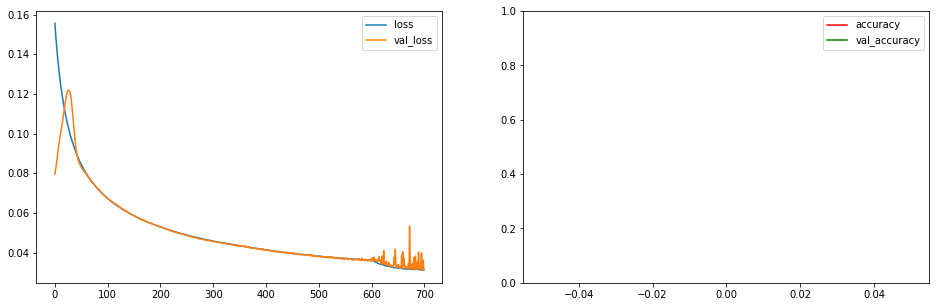

In [139]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))

ax1.plot(np.array(loss),label="loss")
ax1.plot(np.array(val_loss),label="val_loss")
ax1.legend();

ax2.plot(np.array(r2_score),label="accuracy", c="r")
ax2.plot(np.array(val_r2_score),label="val_accuracy", c="g")
ax2.set_ylim(0,1)
ax2.legend();

## Quelques prédictions

In [140]:
hat_Y_test = myVnet.model.predict(X_test)[:,:,:,0]
# hat_Y_test.shape, hat_Y_test.max()

In [141]:
Y_test.shape, hat_Y_test.shape

((183, 64, 64), (183, 64, 64))

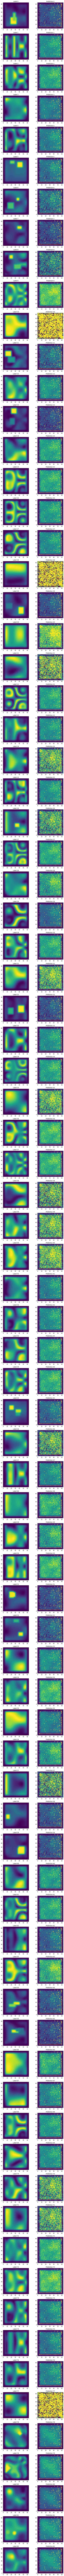

In [142]:
lenTest = int(len(Y_test)/2.2)

fig,ax=plt.subplots(lenTest,2, figsize=(2*5,lenTest*5))

# vmin, vmax = 0, 1
vmin, vmax = None, None

for i in range(lenTest):
    # vmin, vmax = min([Y_test[i].min(), hat_Y_test[i].min()]), max([Y_test[i].max(), hat_Y_test[i].max()])   ## Une échelle particulière a chaque paire (true, predict) 
    vmin, vmax = min([Y_test[i].min()]), max([Y_test[i].max()])
    # if i==0:
    ax[i,0].set_title("Label "+str(i))  
    ax[i,1].set_title("Prédiction "+str(i))  
    ax[i,0].imshow(Y_test[i], origin="lower", vmin=vmin, vmax=vmax)
    ax[i,1].imshow(hat_Y_test[i], origin="lower", vmin=vmin, vmax=vmax)

On constate que...

[(48, 0.026628662), (73, 0.026945852), (82, 0.027067345), (9, 0.027231542), (56, 0.027421009)]


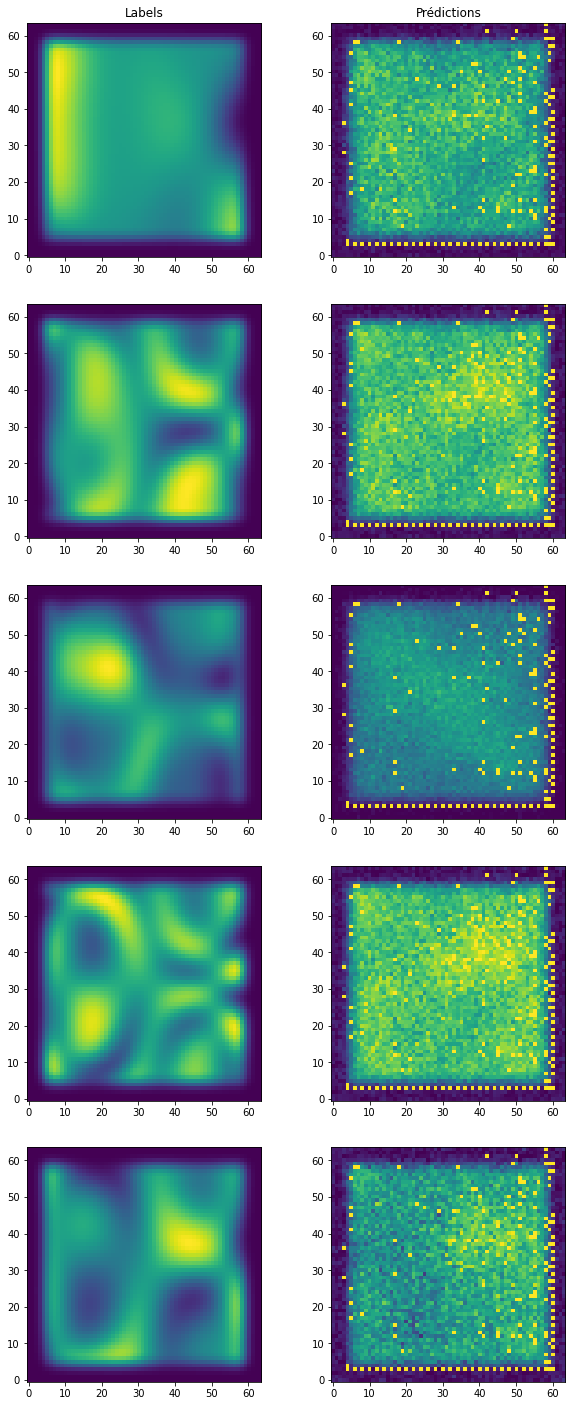

In [143]:
mse = tf.keras.losses.MeanSquaredError()
listErrors = []

for i in range(lenTest):
  listErrors.append((i, mse(Y_test[i], hat_Y_test[i]).numpy()))
  # print(listErrors)

listErrors.sort(key=lambda x:x[1])
print(listErrors[:5])

fig,ax=plt.subplots(5,2, figsize=(2*5,5*5))

for i in range(5):
    Y_true = Y_test[listErrors[i][0]]
    Y_pred = hat_Y_test[listErrors[i][0]]
    vmin, vmax = min([Y_true.min()]), max([Y_true.max()])
    
    if i==0:
      ax[i,0].set_title("Labels")  
      ax[i,1].set_title("Prédictions") 

    ax[i,0].imshow(Y_true, origin="lower", vmin=vmin, vmax=vmax)
    ax[i,1].imshow(Y_pred, origin="lower", vmin=vmin, vmax=vmax)

## Savegarde du model

In [145]:
# myVnet.model.save("VNET01.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
